```Use case/Task: on the given of Titanic dataset, predict the liklihood of person to survive in the future```





# Setup and import

In [1]:
!pip install -q sklearn

In [2]:
%tensorflow_version 2.x

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output # to clear output
from six.moves import urllib

import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc # to create feature columns



# Titanic dataset

Major part of machine learning is data. It's so important to exploring, cleaning and selecting appropriate data.



**Let's load a dataset and learn how to  explore it using some built-in tools. **

In [4]:
# load dataset

data_train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
data_eval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # test data



####  Training vs Testing Data
there are **two different datasets** above. This is because when we train models, we need two sets of data: **training and testing**. 

The **training** data is what we feed to the model so that it can develop and learn. It is usually a much larger size than the testing data.

The **testing** data is what we use to evaulate the model and see how well it is performing. We must use a seperate set of data that the model has not been trained on to evaluate it. Can you think of why this is?

Well, the point of our model is to be able to make predictions on NEW data, data that we have never seen before. If we simply test the model on the data that it has already seen we cannot measure its accuracy accuratly. We can't be sure that the model hasn't simply memorized our training data. This is why we need our testing and training data to be seperate.



In [5]:
# data analysis

#1. see dataset
print(data_train.head(5))

#2 see all the columns
print("All Columns: ",data_train.columns)

#3. all info
print(data_train.info())

#4. mean, standar deviation, maximum, minimum
print(data_train.describe())

   survived     sex   age  ...     deck  embark_town  alone
0         0    male  22.0  ...  unknown  Southampton      n
1         1  female  38.0  ...        C    Cherbourg      n
2         1  female  26.0  ...  unknown  Southampton      y
3         1  female  35.0  ...        C  Southampton      n
4         0    male  28.0  ...  unknown   Queenstown      y

[5 rows x 10 columns]
All Columns:  Index(['survived', 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare',
       'class', 'deck', 'embark_town', 'alone'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            627 non-null    int64  
 1   sex                 627 non-null    object 
 2   age                 627 non-null    float64
 3   n_siblings_spouses  627 non-null    int64  
 4   parch               627 non-null    int64  
 5   fare   

In [6]:
# assigning column to Lable Y

y_train = data_train.pop('survived') # popping this column and assigning it as Lable (we just can't do data_train['survived'] becase these way this couls will also be part of features and Y, which is wrong so we have to pop it out)
y_eval = data_eval.pop('survived')

y_train.head(5)


0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [7]:
data_train.shape # (627, 9)

# 627 = rows/observations, 9 = features


(627, 9)

0      22.0
1      38.0
2      26.0
3      35.0
4      28.0
       ... 
622    28.0
623    25.0
624    19.0
625    28.0
626    32.0
Name: age, Length: 627, dtype: float64


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/hist.py:329: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  ax.hist(values, bins=bins, **kwds)


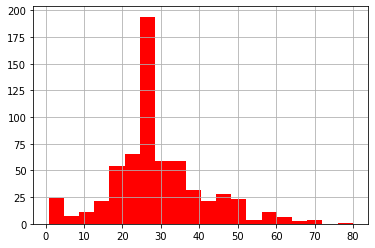

In [8]:
# data plot with age column

print(data_train.age) # this can give age column value
data_train.age.hist(bins=20,color='R')

male      410
female    217
Name: sex, dtype: int64


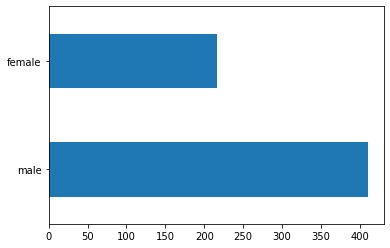

In [9]:
# sex data

print(data_train.sex.value_counts())
data_train.sex.value_counts().plot(kind='barh')

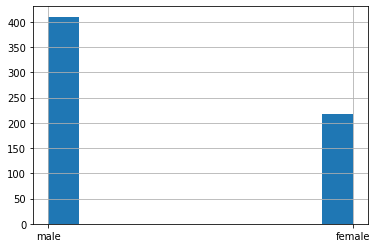

In [10]:
# we can also do this
data_train.sex.hist(bins=10)

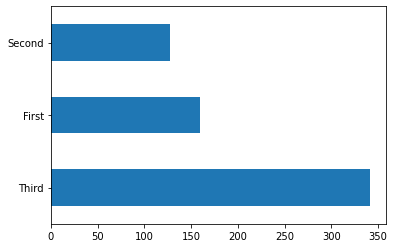

In [11]:
# class columns

data_train['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

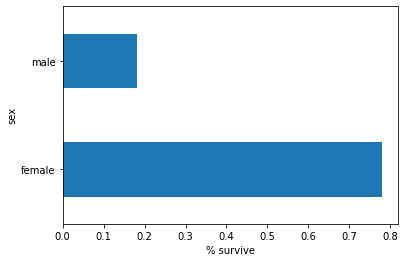

In [12]:
# % survival by sex

pd.concat([data_train,y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

after analyze:

- majority of passenger are in their 20's or 30's
- majority of passenger are male
- majority of passenger are in the 'third' class
- females have a much higher chance to survive





In [13]:
# for male
mask1 = data_train.sex == 'male'
# mask2 = data_train.sex == 'female'
mask3 = data_train.age.between(20, 30)
mask4 = data_train['class'] == 'Third'


male_filtered_df = data_train.loc[mask1 & mask3 & mask4, ['sex', 'age', 'class']]
male_filtered_df.head(5)

,sex,age,class
0,male,22.0,Third
4,male,28.0,Third
9,male,20.0,Third
19,male,28.0,Third
22,male,28.0,Third


In [14]:
# for female

mask2 = data_train.sex == 'female'
mask3 = data_train.age.between(20, 30)
mask4 = data_train['class'] == 'Third'


female_filtered_df = data_train.loc[mask2 & mask3 & mask4, ['sex', 'age', 'class']]
female_filtered_df.head(5)


,sex,age,class
2,female,26.0,Third
6,female,27.0,Third
15,female,28.0,Third
21,female,28.0,Third
25,female,28.0,Third


# Feature Columns
```convert categorcial value into numerical value```


In feature columns we have two different kinds of information: Categorical and Numeric

Our categorical data is anything that is not numeric! For example, the sex column does not use numbers, it uses the words "male" and "female".

Before we continue and create/train a model we must convet our categorical data into numeric data. We can do this by encoding each category with an integer (ex. male = 1, female = 2).

TensorFlow has some tools to help - 
1. ```tf.feature_column.categorical_column_with_vocabulary_list() method```
2. ```tf.feature_column.numeric_column()```

In [15]:
categorical_col = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck','embark_town', 'alone']
numerical_col = ['age','fare']


feature_col = []
for each_feature_name in categorical_col:
  vocab = data_train[each_feature_name].unique() # get a list of all feature one by one
  feature_col.append(tf.feature_column.categorical_column_with_vocabulary_list(each_feature_name, vocab))


for each_feature_name in numerical_col:
  feature_col.append(tf.feature_column.numeric_column(each_feature_name, dtype= tf.float32))


print(feature_col)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

# Model

## The Training Process
How our model is trained. Specifically, how input data is fed to our model. 

For this specific model data is going to be streamed into it in small batches of 32. This means we will not feed the entire dataset to our model at once, but simply small batches of entries. We will feed these batches to our model multiple times according to the number of **epochs**. 

An **epoch** is simply one stream of our entire dataset. The number of epochs we define is the amount of times our model will see the entire dataset. We use multiple epochs in hope that after seeing the same data multiple times the model will better determine how to estimate it.

Example- if we have 10 ephocs, our model will see the same dataset 10 times. 

Since we need to feed our data in batches and multiple times, we need to create something called an **input function**. The input function simply defines how our dataset will be converted into batches at each epoch.





#### Input Function 
- define how batches and epoch are gloing to feed into model.

- The TensorFlow model we are going to use requires that the data we pass it comes in as a ```tf.data.Dataset``` object. This means we must create a *input function* that can convert our current pandas dataframe into that object. 

help: https://www.tensorflow.org/tutorials/estimator/linear

In [16]:
def make_input_function(data_df, label_df, num_of_epochs = 10, shuffle= True, batch_size = 32): # shuffle= True: shuffle/randomize the data value before pass it to model
  def input_function():
    data_set = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) # create a dict of all feature of data_df --> and then pass it to tf.data.Dataset : which create a object with data(data_df) with it's label_df

    if shuffle:
      data_set = data_set.shuffle(1000)
    
    data_set = data_set.batch(batch_size).repeat(num_of_epochs)     # split dataset into batches of 32 and repeat process for number of epochs
    return data_set     # return a batch of the dataset

  return input_function # # return a function object 


train_input_func = make_input_function(data_train, y_train)   # calling input_function to give a dataset object, which we can use for Model
eval_input_func = make_input_function(data_eval, y_eval, num_of_epochs=1, shuffle=False) # we are overriding num_of_epochs=1, shuffle=False here (whereas for train_input_func, epoch (10) and shuffle(true) will be dafult which are passed into function)









# Model Create

- using linear estimator for linear regression

In [20]:
# create Linear estimator

linear_estimator = tf.estimator.LinearClassifier(feature_columns= feature_col)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpd2v73uu8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Model Training

In [22]:
# Train
linear_estimator.train(train_input_func)

# result accuracy on test data: get model metrics/stats
result = linear_estimator.evaluate(eval_input_func)


# clear console output
clear_output()

# print MSE: the result variable is simply a dict of stats about our model
print(result['accuracy'])# 0.7613636 --> 76.13% accuracy




0.7613636


# Prediction

Now we can actually use this model to make predicitons.

We can use the ```.predict()``` method to get survival probabilities from the model. This method will return a list of dicts that store a predicition for each of the entries in our testing data set. Below we've used some pandas magic to plot a nice graph of the predictions.

As you can see the survival rate is not very high :/

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpd2v73uu8/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


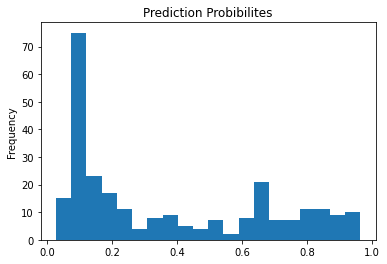

In [26]:
# create dict
prediction_dict= list(linear_estimator.predict(eval_input_func))
# print(prediction_dict)
predict_prob = pd.Series([pred['probabilities'][1] for pred in prediction_dict])
predict_prob.plot(kind = 'hist', bins=20, title='Prediction Probibilites')
